# Case Study - Collared Floater

# Introduction

A **collared floater** pays a floating-rate coupon bounded by a floor and a cap:

$$\max(K_{\text{floor}},\; \min(r,\; K_{\text{cap}}))$$

It can be replicated with three instruments:

| Instrument | Position |
|------------|----------|
| Floating-rate note | +1 |
| Floor (strike = $K_{\text{floor}}$) | +1 |
| Cap (strike = $K_{\text{cap}}$) | -1 |

# Setup


In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Data

Use the data from the following file.
* `../data/fiderivs_2025-03-10.xlsx`

In [3]:
DATE = '2025-03-10'
FILEIN = f'data/fiderivs_{DATE}.xlsx'

curves = pd.read_excel(FILEIN, sheet_name='rate curves').set_index('tenor')
curves.style.format('{:.1%}').format_index('{:.2f}')

,swap rates,spot rates,discounts,forwards,flat vols
tenor,,,,,
0.25,4.2%,4.2%,99.0%,nan%,nan%
0.50,4.1%,4.1%,98.0%,4.0%,14.6%
0.75,4.0%,4.0%,97.1%,3.7%,16.9%
1.00,3.9%,3.9%,96.2%,3.6%,19.1%
1.25,3.8%,3.8%,95.4%,3.4%,22.2%
1.50,3.7%,3.7%,94.6%,3.4%,24.5%
1.75,3.7%,3.7%,93.8%,3.4%,26.1%
2.00,3.7%,3.7%,93.0%,3.5%,27.2%
2.25,3.6%,3.6%,92.2%,3.4%,27.9%


### Parameters


In [4]:
NOTIONAL = 100
T = 5                   # Maturity in years
CPNFREQ = 4             # Quarterly coupons
FREQ_CURVE = 4          # Quarterly compounding

BOUND_LOWER = 0.02      # 2% floor
BOUND_UPPER = 0.05      # 5% cap

# 1. Pricing the Components


### 1.1.

A floater with no credit spread trades at par. Record the floater value.

In [5]:
# 1.1 Floater value (no credit spread)
# A par floater with zero credit spread is worth notional.
pv_floater = NOTIONAL

print(f"Floater value = {pv_floater:.2f}")

Floater value = 100.00


### 1.2.

Price the **floor** (strike = 2%) and the **cap** (strike = 5%).

Use the flat vol at the 5-year tenor from the `curves` table.

Report both prices.

In [6]:
# 1.2 Price floor (2%) and cap (5%) using flat 5Y vol from `curves`
import math
import numpy as np
import pandas as pd

# ---------- helpers ----------
def _pick_col(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for key in candidates:
        for lc, orig in cols.items():
            if key in lc:
                return orig
    raise KeyError(f"Could not find a column matching any of: {candidates}")

def _norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def _black76_call(F, K, vol, tau):
    if tau <= 0 or vol <= 0:
        return max(F - K, 0.0)
    s = vol * math.sqrt(tau)
    d1 = (math.log(F / K) + 0.5 * s * s) / s
    d2 = d1 - s
    return F * _norm_cdf(d1) - K * _norm_cdf(d2)

def _black76_put(F, K, vol, tau):
    if tau <= 0 or vol <= 0:
        return max(K - F, 0.0)
    s = vol * math.sqrt(tau)
    d1 = (math.log(F / K) + 0.5 * s * s) / s
    d2 = d1 - s
    return K * _norm_cdf(-d2) - F * _norm_cdf(-d1)

# ---------- pull curve inputs ----------
spot_col = _pick_col(curves, ["spot", "zero", "rate"])
vol_col = _pick_col(curves, ["flat vol", "vol"])

tenors = curves.index.astype(float).values
spots = curves[spot_col].astype(float).values
vols = curves[vol_col].astype(float).values

# flat vol at 5Y tenor (interpolate if needed)
sigma = float(np.interp(T, tenors, vols))

# ---------- build caplet/floorlet schedule ----------
delta = 1.0 / CPNFREQ
pay_times = np.arange(1, int(T * CPNFREQ) + 1) * delta
fix_times = pay_times - delta

def _df_from_spot_periodic(t):
    r_t = float(np.interp(t, tenors, spots))
    return 1.0 / (1.0 + r_t / FREQ_CURVE) ** (FREQ_CURVE * t)

# discount factors at period start/end
df_start = np.array([_df_from_spot_periodic(t0) for t0 in fix_times], dtype=float)
df_end = np.array([_df_from_spot_periodic(t1) for t1 in pay_times], dtype=float)

# forward rate for each accrual period
fwds = (df_start / df_end - 1.0) / delta

# ---------- cap/floor valuation (sum of caplets/floorlets) ----------
caplets = []
floorlets = []

for F, t_fix, df_pay in zip(fwds, fix_times, df_end):
    tau = max(float(t_fix), 0.0)  # option maturity to fixing date
    caplet = NOTIONAL * delta * df_pay * _black76_call(F, BOUND_UPPER, sigma, tau)
    floorlet = NOTIONAL * delta * df_pay * _black76_put(F, BOUND_LOWER, sigma, tau)
    caplets.append(caplet)
    floorlets.append(floorlet)

pv_cap = float(np.sum(caplets))
pv_floor = float(np.sum(floorlets))

pd.DataFrame(
    {
        "instrument": ["Floor (K=2%)", "Cap (K=5%)"],
        "price": [pv_floor, pv_cap],
    }
).style.format({"price": "{:.4f}"})

,instrument,price
0,Floor (K=2%),0.2449
1,Cap (K=5%),0.9773


### 1.3.

Combine the three instruments into the replicating portfolio:
* +1 Floater
* +1 Floor (2%)
* -1 Cap (5%)

Report the NAV of each component and the total portfolio value.

Is the portfolio worth more or less than par? Why?


In [8]:
# 1.3 Replicating portfolio NAV: + Floater + Floor - Cap
nav_floater = pv_floater
nav_floor = pv_floor
nav_cap_short = -pv_cap

pv_portfolio = nav_floater + nav_floor + nav_cap_short

nav_table = pd.DataFrame(
    {
        "component": ["+ Floater", "+ Floor (K=2%)", "- Cap (K=5%)", "Total Portfolio"],
        "NAV": [nav_floater, nav_floor, nav_cap_short, pv_portfolio],
    }
)

display(nav_table.style.format({"NAV": "{:.4f}"}))

# Compare to par
diff_vs_par = pv_portfolio - NOTIONAL
direction = "more" if diff_vs_par > 0 else "less" if diff_vs_par < 0 else "equal"

print(f"Portfolio value = {pv_portfolio:.4f}")
print(f"Difference vs par ({NOTIONAL:.2f}) = {diff_vs_par:+.4f}")

,component,NAV
0,+ Floater,100.0000
1,+ Floor (K=2%),0.2449
2,- Cap (K=5%),-0.9773
3,Total Portfolio,99.2676


Portfolio value = 99.2676
Difference vs par (100.00) = -0.7324


The portfolio is worth less than par, because the short cap is more valuable than the long floor (we give up more upside than downside protection gained).

# 2. Risk Analysis


### 2.1.

Calculate the **duration** of the portfolio numerically by applying a 1bp parallel shock to the spot curve.

Report the duration of each component and the portfolio.

In [9]:
# 2.1 Numerical duration with a +1bp parallel shock to spot curve
bump_bp = 1.0
dy = bump_bp / 10000.0

# Reuse objects from 1.2; create only if missing
if "spot_col" not in globals():
    spot_col = _pick_col(curves, ["spot", "zero", "rate"])
if "vol_col" not in globals():
    vol_col = _pick_col(curves, ["flat vol", "vol"])
if "tenors" not in globals():
    tenors = curves.index.astype(float).values
if "spots" not in globals():
    spots = curves[spot_col].astype(float).values
if "vols" not in globals():
    vols = curves[vol_col].astype(float).values
if "sigma" not in globals():
    sigma = float(np.interp(T, tenors, vols))
if "delta" not in globals():
    delta = 1.0 / CPNFREQ
if "pay_times" not in globals() or "fix_times" not in globals():
    pay_times = np.arange(1, int(T * CPNFREQ) + 1) * delta
    fix_times = pay_times - delta

def _price_cap_floor_from_spot_curve(spots_input):
    def _df_t(t):
        r_t = float(np.interp(t, tenors, spots_input))
        return 1.0 / (1.0 + r_t / FREQ_CURVE) ** (FREQ_CURVE * t)

    df_start = np.array([_df_t(t0) for t0 in fix_times], dtype=float)
    df_end = np.array([_df_t(t1) for t1 in pay_times], dtype=float)
    fwds = (df_start / df_end - 1.0) / delta

    caplets, floorlets = [], []
    for F, t_fix, df_pay in zip(fwds, fix_times, df_end):
        tau = max(float(t_fix), 0.0)
        caplets.append(NOTIONAL * delta * df_pay * _black76_call(F, BOUND_UPPER, sigma, tau))
        floorlets.append(NOTIONAL * delta * df_pay * _black76_put(F, BOUND_LOWER, sigma, tau))

    return float(np.sum(floorlets)), float(np.sum(caplets))  # floor, cap

# Base values from prior sections (recompute if not present)
if "pv_floater" not in globals():
    pv_floater = NOTIONAL
if "pv_floor" not in globals() or "pv_cap" not in globals():
    pv_floor, pv_cap = _price_cap_floor_from_spot_curve(spots)

# Bumped curve (+1bp everywhere)
spots_up = spots + dy
pv_floor_up, pv_cap_up = _price_cap_floor_from_spot_curve(spots_up)
pv_floater_up = pv_floater  # par floater, no spread => remains at par in this setup

# Signed component NAVs (matching the portfolio definition in 1.3)
base = {
    "+ Floater": pv_floater,
    "+ Floor (K=2%)": pv_floor,
    "- Cap (K=5%)": -pv_cap,
}
bump = {
    "+ Floater": pv_floater_up,
    "+ Floor (K=2%)": pv_floor_up,
    "- Cap (K=5%)": -pv_cap_up,
}

base["Portfolio"] = sum(base.values())
bump["Portfolio"] = sum(bump.values())

def _duration(p0, p_up, d_y):
    return np.nan if abs(p0) < 1e-12 else -(p_up - p0) / (p0 * d_y)

rows = []
for k in ["+ Floater", "+ Floor (K=2%)", "- Cap (K=5%)", "Portfolio"]:
    p0 = base[k]
    p1 = bump[k]
    rows.append(
        {
            "component": k,
            "PV_base": p0,
            "PV_up_1bp": p1,
            "dPV": p1 - p0,
            "duration": _duration(p0, p1, dy),
        }
    )

dur_tbl = pd.DataFrame(rows)
display(dur_tbl.style.format({"PV_base": "{:.6f}", "PV_up_1bp": "{:.6f}", "dPV": "{:+.6f}", "duration": "{:.6f}"}))

,component,PV_base,PV_up_1bp,dPV,duration
0,+ Floater,100.000000,100.000000,+0.000000,0.000000
1,+ Floor (K=2%),0.244911,0.242382,-0.002529,103.243909
2,- Cap (K=5%),-0.977314,-0.988071,-0.010757,-110.067521
3,Portfolio,99.267597,99.254311,-0.013286,1.338363


### 2.2.

Calculate the **OAS** of the portfolio.

If the market quotes this note at par (100.00), what parallel shift to the spot curve would match that price?

Use `fsolve` to find the OAS.

In [10]:
# 2.2 OAS via fsolve: find parallel spot shift that makes portfolio value = par
TARGET_PRICE = 100.0  # market quote at par

# Ensure required objects from prior cells exist
if "spots" not in globals():
    spot_col = _pick_col(curves, ["spot", "zero", "rate"])
    tenors = curves.index.astype(float).values
    spots = curves[spot_col].astype(float).values

if "pv_floater" not in globals():
    pv_floater = NOTIONAL

if "_price_cap_floor_from_spot_curve" not in globals():
    # Fallback (same logic as prior exercise) in case 2.1 cell was not run
    if "vol_col" not in globals():
        vol_col = _pick_col(curves, ["flat vol", "vol"])
    if "vols" not in globals():
        vols = curves[vol_col].astype(float).values
    if "sigma" not in globals():
        sigma = float(np.interp(T, tenors, vols))
    if "delta" not in globals():
        delta = 1.0 / CPNFREQ
    if "pay_times" not in globals() or "fix_times" not in globals():
        pay_times = np.arange(1, int(T * CPNFREQ) + 1) * delta
        fix_times = pay_times - delta

    def _price_cap_floor_from_spot_curve(spots_input):
        def _df_t(t):
            r_t = float(np.interp(t, tenors, spots_input))
            return 1.0 / (1.0 + r_t / FREQ_CURVE) ** (FREQ_CURVE * t)

        df_start = np.array([_df_t(t0) for t0 in fix_times], dtype=float)
        df_end = np.array([_df_t(t1) for t1 in pay_times], dtype=float)
        fwds = (df_start / df_end - 1.0) / delta

        caplets, floorlets = [], []
        for F, t_fix, df_pay in zip(fwds, fix_times, df_end):
            tau = max(float(t_fix), 0.0)
            caplets.append(NOTIONAL * delta * df_pay * _black76_call(F, BOUND_UPPER, sigma, tau))
            floorlets.append(NOTIONAL * delta * df_pay * _black76_put(F, BOUND_LOWER, sigma, tau))

        return float(np.sum(floorlets)), float(np.sum(caplets))  # floor, cap

def portfolio_value_from_shift(shift_decimal):
    """Parallel shift to spot curve in decimal terms (e.g. 0.0001 = +1bp)."""
    shifted_spots = spots + float(shift_decimal)
    pv_floor_s, pv_cap_s = _price_cap_floor_from_spot_curve(shifted_spots)
    return pv_floater + pv_floor_s - pv_cap_s

def objective(shift_arr):
    s = float(np.atleast_1d(shift_arr)[0])
    return portfolio_value_from_shift(s) - TARGET_PRICE

# Solve for OAS (in decimal rate units)
oas_decimal = float(fsolve(objective, x0=0.0)[0])
oas_bp = oas_decimal * 10000.0

# Check result
pv_at_oas = portfolio_value_from_shift(oas_decimal)

out = pd.DataFrame(
    {
        "metric": ["Target market price", "Solved OAS (bp)", "Solved OAS (%)", "Model price at solved OAS"],
        "value": [TARGET_PRICE, oas_bp, 100.0 * oas_decimal, pv_at_oas],
    }
)

display(out.style.format({"value": "{:.6f}"}))
print(f"OAS = {oas_bp:.3f} bp ({100*oas_decimal:.4f}%)")
print(f"Check: portfolio PV at OAS = {pv_at_oas:.6f}")

,metric,value
0,Target market price,100.000000
1,Solved OAS (bp),-59.833110
2,Solved OAS (%),-0.598331
3,Model price at solved OAS,100.000000


OAS = -59.833 bp (-0.5983%)
Check: portfolio PV at OAS = 100.000000


### 2.3.

Plot the portfolio value across a range of interest rate scenarios (shock the spot curve from -300bp to +300bp).

On your plot, mark the current rate, the floor (2%), and the cap (5%).

Describe what you see in terms of convexity.

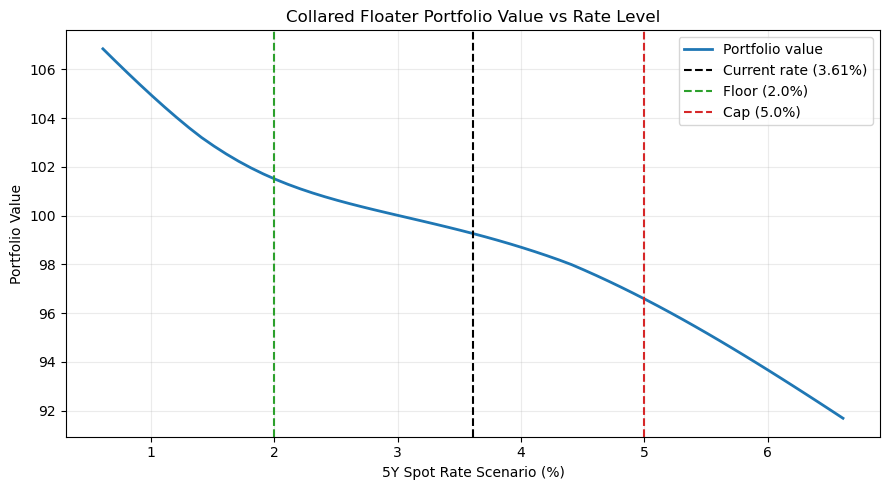

In [12]:
# 2.3 Portfolio value vs parallel rate shocks (-300bp to +300bp)

# Ensure base 5Y spot is available
if "tenors" not in globals() or "spots" not in globals():
    spot_col = _pick_col(curves, ["spot", "zero", "rate"])
    tenors = curves.index.astype(float).values
    spots = curves[spot_col].astype(float).values

# Ensure portfolio pricer is available (from 2.2)
if "portfolio_value_from_shift" not in globals():
    def portfolio_value_from_shift(shift_decimal):
        shifted_spots = spots + float(shift_decimal)
        pv_floor_s, pv_cap_s = _price_cap_floor_from_spot_curve(shifted_spots)
        return pv_floater + pv_floor_s - pv_cap_s

# Shock grid
shock_bps = np.arange(-300, 301, 10)                 # -300bp ... +300bp
shock_dec = shock_bps / 10000.0
pv_scn = np.array([portfolio_value_from_shift(s) for s in shock_dec], dtype=float)

# Map to an "effective current-rate" x-axis using 5Y spot + shock
base_rate_5y = float(np.interp(T, tenors, spots))
x_rate = base_rate_5y + shock_dec

# Plot
plt.figure(figsize=(9, 5))
plt.plot(x_rate * 100, pv_scn, lw=2, label="Portfolio value")

# Mark current rate, floor, cap
plt.axvline(base_rate_5y * 100, color="black", ls="--", lw=1.5, label=f"Current rate ({base_rate_5y*100:.2f}%)")
plt.axvline(BOUND_LOWER * 100, color="tab:green", ls="--", lw=1.5, label=f"Floor ({BOUND_LOWER*100:.1f}%)")
plt.axvline(BOUND_UPPER * 100, color="tab:red", ls="--", lw=1.5, label=f"Cap ({BOUND_UPPER*100:.1f}%)")

plt.title("Collared Floater Portfolio Value vs Rate Level")
plt.xlabel("5Y Spot Rate Scenario (%)")
plt.ylabel("Portfolio Value")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

Above we can see that the portfolio has positive convexity for negative interest rate shocks, while it has negative convexity for positive interest rate shocks.

# 3. Stress Test: A +300bp Shock


In 1994, the Federal Reserve raised rates roughly 300bp in under a year, causing large losses on structured note portfolios — most notably Orange County's $1.7 billion loss.

Orange County held primarily **inverse floaters** (coupon = Fixed Rate $-$ Multiplier $\times$ Floating Rate), which are more aggressive than a collared floater. But it is instructive to see what a +300bp shock does to our product.


### 3.1.

Compute the portfolio value after a +300bp parallel shock to the spot curve.

Report the percentage loss.

In [13]:
# 3.1 Stress test: +300bp parallel shock
shock_bp = 300.0
shock_dec = shock_bp / 10000.0

# Base portfolio value (from previous sections)
if "pv_portfolio" in globals():
    pv_base = float(pv_portfolio)
else:
    # fallback if 1.3 cell wasn't run
    if "pv_floor" not in globals() or "pv_cap" not in globals():
        pv_floor, pv_cap = _price_cap_floor_from_spot_curve(spots)
    if "pv_floater" not in globals():
        pv_floater = NOTIONAL
    pv_base = float(pv_floater + pv_floor - pv_cap)

# Shocked value
pv_shocked = float(portfolio_value_from_shift(shock_dec))

# Loss metrics
loss_abs = pv_base - pv_shocked
loss_pct = 100.0 * loss_abs / pv_base

res_31 = pd.DataFrame(
    {
        "metric": [
            "Base portfolio value",
            "Portfolio value after +300bp shock",
            "Absolute loss",
            "Percentage loss",
        ],
        "value": [pv_base, pv_shocked, loss_abs, loss_pct],
    }
)

display(res_31.style.format({"value": "{:.6f}"}))
print(f"+300bp shocked portfolio value = {pv_shocked:.6f}")
print(f"Percentage loss = {loss_pct:.4f}%")

,metric,value
0,Base portfolio value,99.267597
1,Portfolio value after +300bp shock,91.691277
2,Absolute loss,7.576320
3,Percentage loss,7.632218


+300bp shocked portfolio value = 91.691277
Percentage loss = 7.6322%


### 3.2.

Orange County's investment pool was leveraged roughly 2.5x.

If we apply the same leverage to the loss from 3.1, what is the leveraged loss?

How does it compare to Orange County's actual 22.3% loss? Why is the gap so large?


In [15]:
# 3.2 Apply Orange County-style leverage (2.5x) to 3.1 loss
LEVERAGE = 2.5
ORANGE_COUNTY_LOSS_PCT = 22.3

# Reuse 3.1 output if available; otherwise rebuild quickly
if "loss_pct" not in globals():
    shock_dec = 300.0 / 10000.0
    if "pv_portfolio" in globals():
        pv_base = float(pv_portfolio)
    else:
        pv_base = float(pv_floater + pv_floor - pv_cap)
    pv_shocked = float(portfolio_value_from_shift(shock_dec))
    loss_pct = 100.0 * (pv_base - pv_shocked) / pv_base

leveraged_loss_pct = LEVERAGE * float(loss_pct)
gap_pct_points = leveraged_loss_pct - ORANGE_COUNTY_LOSS_PCT

res_32 = pd.DataFrame(
    {
        "metric": [
            "Unlevered loss from 3.1 (%)",
            "Assumed leverage (x)",
            "Leveraged loss (%)",
            "Orange County actual loss (%)",
            "Gap (leveraged model - actual, % points)",
        ],
        "value": [
            float(loss_pct),
            LEVERAGE,
            leveraged_loss_pct,
            ORANGE_COUNTY_LOSS_PCT,
            gap_pct_points,
        ],
    }
)

display(res_32.style.format({"value": "{:.4f}"}))

print(f"Leveraged loss = {leveraged_loss_pct:.2f}% vs Orange County = {ORANGE_COUNTY_LOSS_PCT:.2f}%")

,metric,value
0,Unlevered loss from 3.1 (%),7.6322
1,Assumed leverage (x),2.5000
2,Leveraged loss (%),19.0805
3,Orange County actual loss (%),22.3000
4,"Gap (leveraged model - actual, % points)",-3.2195


Leveraged loss = 19.08% vs Orange County = 22.30%


Why the gap is large:
- Orange County held more aggressive inverse floaters (higher negative rate convexity).
- Their portfolio mix, funding structure, and path-dependent dynamics differed from this simple collared floater.
- This exercise uses a stylized parallel-shock repricing, not full market/liquidity/funding stress.

# 4. Optional: Volatility Skew

*Requires SABR (Chapter 8).*

### 4.1.

The analysis above uses a single flat vol for both the cap and floor. In practice, implied volatility varies with strike.

Using the SABR parameters below (estimated in `E.8.2. SABR Calibration`), compute the SABR-implied vol at each strike (2% and 5%).

| Parameter | Value |
|-----------|-------|
| beta | 0.25 |
| alpha | 0.0214 |
| nu | 0.60 |
| rho | -0.20 |

Use the 5-year forward rate as the forward.


In [16]:
# 4.1 SABR-implied vols at K=2% and K=5% using 5Y forward as F

# SABR parameters from prompt
beta = 0.25
alpha = 0.0214
nu = 0.60
rho = -0.20

# Ensure we have curve arrays from earlier sections
if "tenors" not in globals() or "spots" not in globals():
    spot_col = _pick_col(curves, ["spot", "zero", "rate"])
    tenors = curves.index.astype(float).values
    spots = curves[spot_col].astype(float).values

# Discount-factor helper (periodic compounding, consistent with earlier setup)
def _df_from_spot_periodic_local(t):
    r_t = float(np.interp(t, tenors, spots))
    return 1.0 / (1.0 + r_t / FREQ_CURVE) ** (FREQ_CURVE * t)

# 5Y forward rate: prefer "forward" column if present, else infer from DFs
fwd_cols = [c for c in curves.columns if "forward" in c.lower()]
if len(fwd_cols) > 0:
    F_5y = float(np.interp(T, tenors, curves[fwd_cols[0]].astype(float).values))
else:
    # Infer a 3m forward ending at 5Y: F(4.75, 5.00)
    delta = 1.0 / CPNFREQ
    t0, t1 = T - delta, T
    df0 = _df_from_spot_periodic_local(t0)
    df1 = _df_from_spot_periodic_local(t1)
    F_5y = (df0 / df1 - 1.0) / delta

def sabr_implied_vol_hagan(F, K, Texp, alpha, beta, rho, nu):
    """
    Hagan et al. (2002) lognormal SABR implied vol approximation.
    """
    eps = 1e-12
    F = max(float(F), eps)
    K = max(float(K), eps)

    if abs(F - K) < 1e-10:
        FKb = F ** (1.0 - beta)
        term1 = alpha / FKb
        term2 = ((1.0 - beta) ** 2 / 24.0) * (alpha**2 / (F ** (2.0 - 2.0 * beta)))
        term3 = (rho * beta * nu * alpha) / (4.0 * (F ** (1.0 - beta)))
        term4 = ((2.0 - 3.0 * rho**2) / 24.0) * nu**2
        return term1 * (1.0 + (term2 + term3 + term4) * Texp)

    logFK = np.log(F / K)
    FK = F * K
    FK_pow = FK ** ((1.0 - beta) / 2.0)

    z = (nu / alpha) * FK_pow * logFK
    xz = np.log((np.sqrt(1.0 - 2.0 * rho * z + z * z) + z - rho) / (1.0 - rho))

    A = alpha / (FK_pow * (1.0 + ((1.0 - beta) ** 2 / 24.0) * logFK**2 + ((1.0 - beta) ** 4 / 1920.0) * logFK**4))
    B = z / xz
    C = 1.0 + (
        ((1.0 - beta) ** 2 / 24.0) * (alpha**2 / (FK ** (1.0 - beta)))
        + (rho * beta * nu * alpha) / (4.0 * (FK ** ((1.0 - beta) / 2.0)))
        + ((2.0 - 3.0 * rho**2) / 24.0) * nu**2
    ) * Texp

    return A * B * C

# Compute SABR vols at the two strikes
K_floor = BOUND_LOWER
K_cap = BOUND_UPPER
Texp = T

vol_floor_sabr = float(sabr_implied_vol_hagan(F_5y, K_floor, Texp, alpha, beta, rho, nu))
vol_cap_sabr = float(sabr_implied_vol_hagan(F_5y, K_cap, Texp, alpha, beta, rho, nu))

res_41 = pd.DataFrame(
    {
        "item": ["Forward used (5Y)", "SABR vol @ K=2%", "SABR vol @ K=5%"],
        "value": [F_5y, vol_floor_sabr, vol_cap_sabr],
    }
)

display(res_41.style.format({"value": "{:.6%}"}))
print(f"5Y forward F = {F_5y:.6%}")
print(f"SABR implied vol at 2% strike = {vol_floor_sabr:.6%}")
print(f"SABR implied vol at 5% strike = {vol_cap_sabr:.6%}")

,item,value
0,Forward used (5Y),3.719975%
1,SABR vol @ K=2%,45.128670%
2,SABR vol @ K=5%,26.223962%


5Y forward F = 3.719975%
SABR implied vol at 2% strike = 45.128670%
SABR implied vol at 5% strike = 26.223962%


### 4.2.

Re-price the floor and cap using the SABR-implied vols (one vol per instrument).

Compare the flat-vol portfolio value to the SABR-adjusted portfolio value. Which direction does the skew push the price, and why?


Part 2 (C.9.1) values the same product using binomial trees.

In [17]:
# 4.2 Re-price floor/cap with SABR vols and compare to flat-vol portfolio

# Ensure key objects exist from prior sections
if "pv_floater" not in globals():
    pv_floater = NOTIONAL

if "delta" not in globals():
    delta = 1.0 / CPNFREQ
if "pay_times" not in globals() or "fix_times" not in globals():
    pay_times = np.arange(1, int(T * CPNFREQ) + 1) * delta
    fix_times = pay_times - delta

if "tenors" not in globals() or "spots" not in globals():
    spot_col = _pick_col(curves, ["spot", "zero", "rate"])
    tenors = curves.index.astype(float).values
    spots = curves[spot_col].astype(float).values

if "sigma" not in globals():
    vol_col = _pick_col(curves, ["flat vol", "vol"])
    vols = curves[vol_col].astype(float).values
    sigma = float(np.interp(T, tenors, vols))

def _price_cap_floor_with_two_vols(spots_input, vol_floor, vol_cap):
    def _df_t(t):
        r_t = float(np.interp(t, tenors, spots_input))
        return 1.0 / (1.0 + r_t / FREQ_CURVE) ** (FREQ_CURVE * t)

    df_start = np.array([_df_t(t0) for t0 in fix_times], dtype=float)
    df_end = np.array([_df_t(t1) for t1 in pay_times], dtype=float)
    fwds = (df_start / df_end - 1.0) / delta

    caplets, floorlets = [], []
    for F, t_fix, df_pay in zip(fwds, fix_times, df_end):
        tau = max(float(t_fix), 0.0)
        caplets.append(NOTIONAL * delta * df_pay * _black76_call(F, BOUND_UPPER, vol_cap, tau))
        floorlets.append(NOTIONAL * delta * df_pay * _black76_put(F, BOUND_LOWER, vol_floor, tau))

    return float(np.sum(floorlets)), float(np.sum(caplets))

# Flat-vol pricing (baseline)
pv_floor_flat, pv_cap_flat = _price_cap_floor_with_two_vols(spots, sigma, sigma)
pv_port_flat = pv_floater + pv_floor_flat - pv_cap_flat

# SABR-vol pricing (one vol per instrument from 4.1)
pv_floor_sabr, pv_cap_sabr = _price_cap_floor_with_two_vols(spots, vol_floor_sabr, vol_cap_sabr)
pv_port_sabr = pv_floater + pv_floor_sabr - pv_cap_sabr

# Comparison
delta_port = pv_port_sabr - pv_port_flat

cmp = pd.DataFrame(
    {
        "metric": [
            "Floor PV (flat vol)",
            "Cap PV (flat vol)",
            "Portfolio PV (flat vol)",
            "Floor PV (SABR vol)",
            "Cap PV (SABR vol)",
            "Portfolio PV (SABR vol)",
            "SABR - Flat (portfolio)",
        ],
        "value": [
            pv_floor_flat,
            pv_cap_flat,
            pv_port_flat,
            pv_floor_sabr,
            pv_cap_sabr,
            pv_port_sabr,
            delta_port,
        ],
    }
)

display(cmp.style.format({"value": "{:.6f}"}))

print(f"Flat-vol portfolio PV  = {pv_port_flat:.6f}")
print(f"SABR-vol portfolio PV  = {pv_port_sabr:.6f}")
print(f"Difference (SABR-Flat) = {delta_port:+.6f}")

print("\nSkew interpretation:")
if delta_port > 0:
    print("- Skew pushes the collared floater price UP.")
    print("- Intuition: left-tail vol (near/lower strike) tends to be higher, making the long floor relatively richer than the short cap.")
elif delta_port < 0:
    print("- Skew pushes the collared floater price DOWN.")
    print("- Intuition: right-side vol (near/higher strike) is relatively higher, making the short cap liability grow more than the long floor benefit.")
else:
    print("- Minimal net skew impact in this setup.")

,metric,value
0,Floor PV (flat vol),0.244911
1,Cap PV (flat vol),0.977314
2,Portfolio PV (flat vol),99.267597
3,Floor PV (SABR vol),0.887883
4,Cap PV (SABR vol),0.840210
5,Portfolio PV (SABR vol),100.047673
6,SABR - Flat (portfolio),0.780076


Flat-vol portfolio PV  = 99.267597
SABR-vol portfolio PV  = 100.047673
Difference (SABR-Flat) = +0.780076

Skew interpretation:
- Skew pushes the collared floater price UP.
- Intuition: left-tail vol (near/lower strike) tends to be higher, making the long floor relatively richer than the short cap.
